<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

Model training and fine-tuning requires constant attention, but no one can monitor dashboards around the clock. That's why W&B Models has added customizable alerts for tracking your most important metrics.

Here, you'll learn how to use the API to set up alerts to send you Slack messages when your run metrics spike.
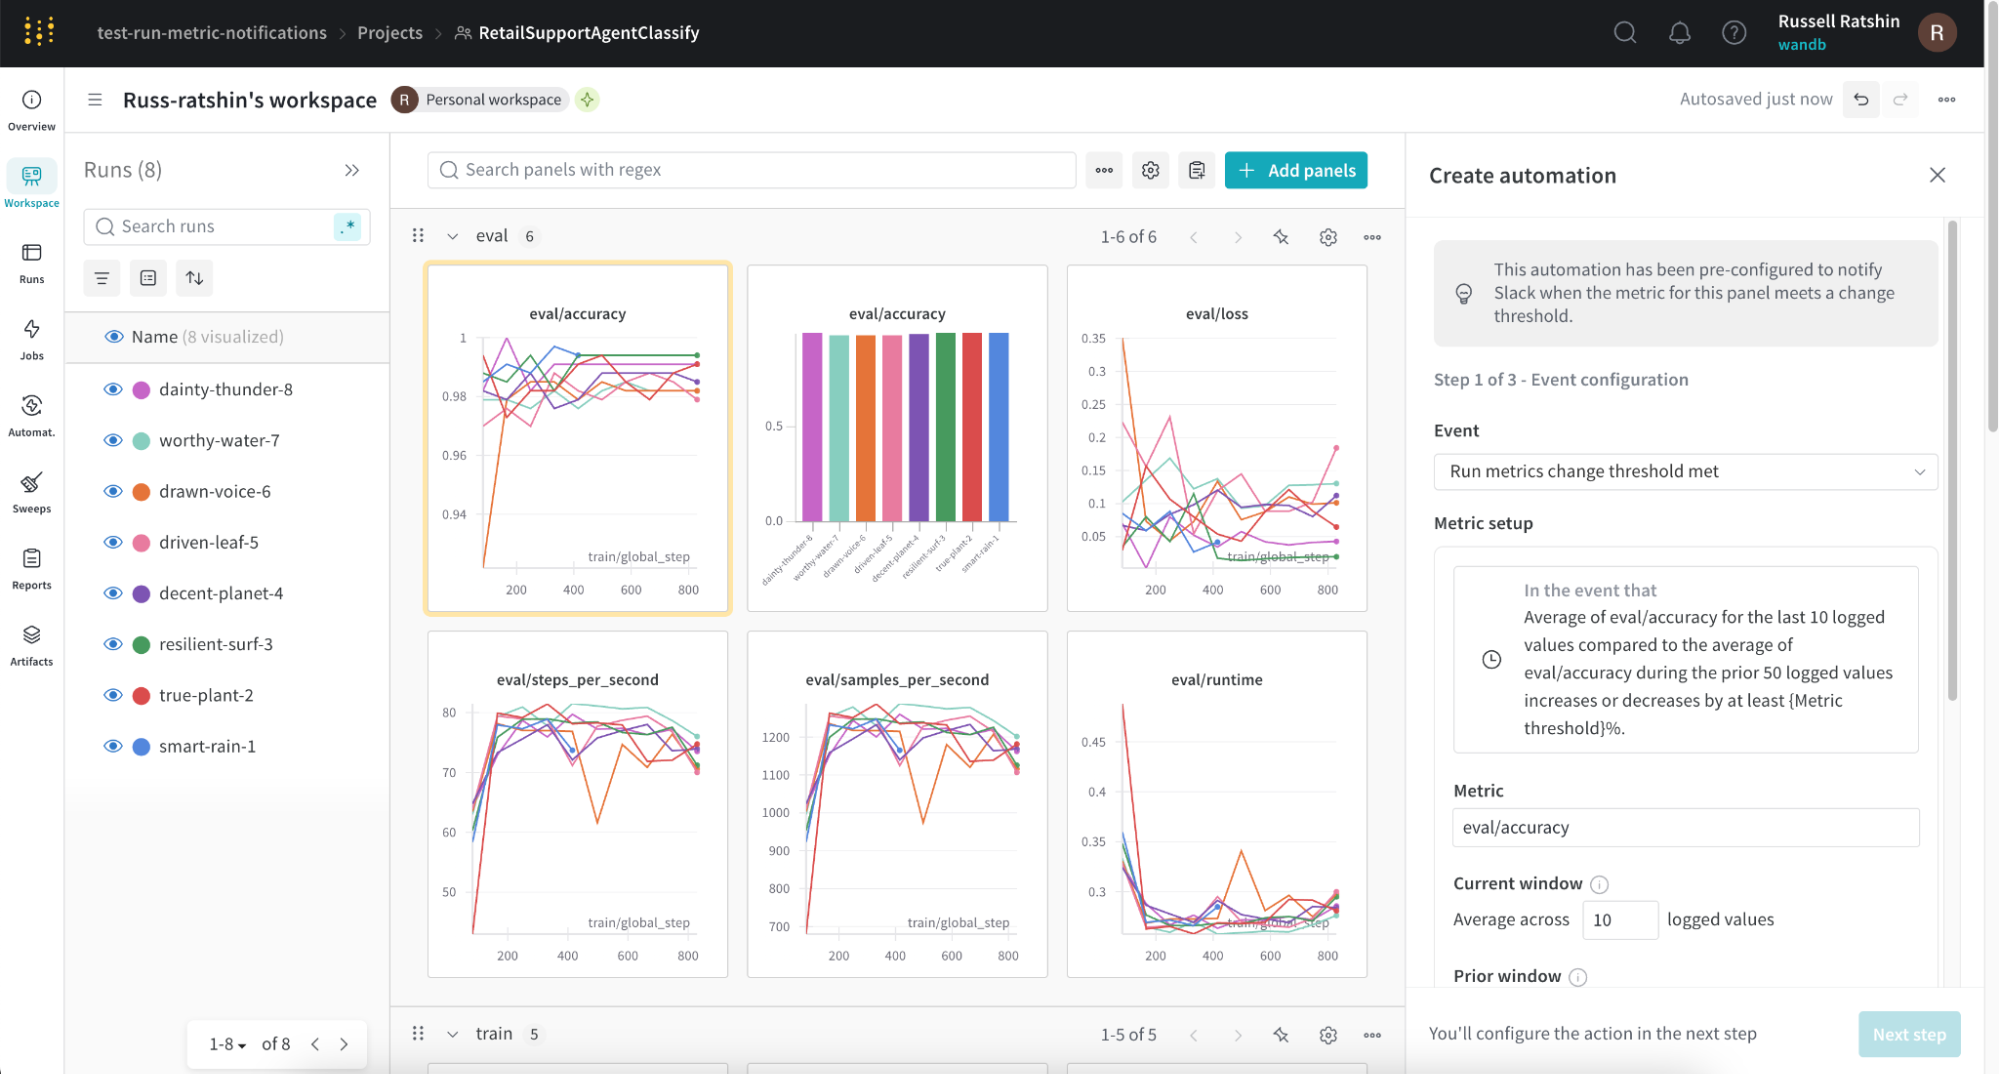


## Setup

Install dependencies and configure API keys.

In [ ]:
pip install -qU wandb

In [ ]:
import wandb
import random
import math
import time

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tristan-spaulding (wandb-smle) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
TEAM_NAME = "" ## Add your team
PROJECT_NAME = "notifications-api-quickstart"
SLACK_CHANNEL = "" ##add your slack channel name

## Define alerts

We'll create a run filter to only look at some runs, then define an alert to fire when a metric increases by at least 10% over the last 10 steps compared to the previous ten.

In [ ]:
from wandb import Api

from wandb.automations import OnRunMetric, RunEvent, SendNotification

api = Api()
api.create_project(PROJECT_NAME, entity=TEAM_NAME)
project = api.project(PROJECT_NAME)

# ------------------------------------------------------------------------------

run_filter = RunEvent.name.contains("volcanic")

# ... the average of "val_loss" (last 10 values) is 10% higher
metric_filter = RunEvent.metric("val/loss").avg(10).increases_by(frac=0.1)

event = OnRunMetric(
    scope=project,
    filter=run_filter & metric_filter,
)

# Select your Slack integration
slack_integration = next(
    slack for slack in api.slack_integrations(entity=TEAM_NAME)
    if slack.channel_name == SLACK_CHANNEL
)

# Define the triggered action: send notification to Slack
action = SendNotification.from_integration(
    slack_integration,
    text=":worried: val/loss has spiked more than 10% for the last 10 steps.",
    level="WARN"
)

# ------------------------------------------------------------------------------
# Create the automation
automation = api.create_automation(
    event >> action,
    name="val/loss spike (relative)",
    description="Slack notification when val/loss spikes for 10+ steps."
)


## Triggering the alert

Now we'll start a run that will trigger the alert, and we should see the message appear in the Slack channel we designated.

In [ ]:

run_name = f"volcanic-iguana-{random.randint(0,20)}"
run = wandb.init(project=PROJECT_NAME, entity=TEAM_NAME, name=run_name)

# Define the shape of our loss curve
start_loss = 1.0

end_loss = 0.2
num_steps_decline = 100
decay_rate = 4.0    # Increase for sharper initial drop
noise_level = 0.02  # Adjust noise to simulate real fluctuations

# Log an exponential decay from start_loss to end_loss
for step in range(num_steps_decline):
    fraction = step / (num_steps_decline - 1)
    # Exponential decay: as fraction increases, loss asymptotes towards end_loss
    ideal_loss = end_loss + (start_loss - end_loss) * math.exp(-decay_rate * fraction)
    # Add a bit of random noise around that value
    noisy_loss = ideal_loss + random.uniform(-noise_level, noise_level)
    # Ensure loss doesn't drop below 0
    current_loss = max(noisy_loss, 0.0)
    run.log({"val/loss": current_loss})
    time.sleep(0.02)  # Slow down each logging step

# After the decline, spike above 0.95 for at least 10 steps
for _ in range(10):
    run.log({"val/loss": random.uniform(0.95, 1.0)})
    time.sleep(0.25)

wandb.finish()
print("Finished")

val/loss,▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁█████
val/loss,0.96826


Finished


## That's it!

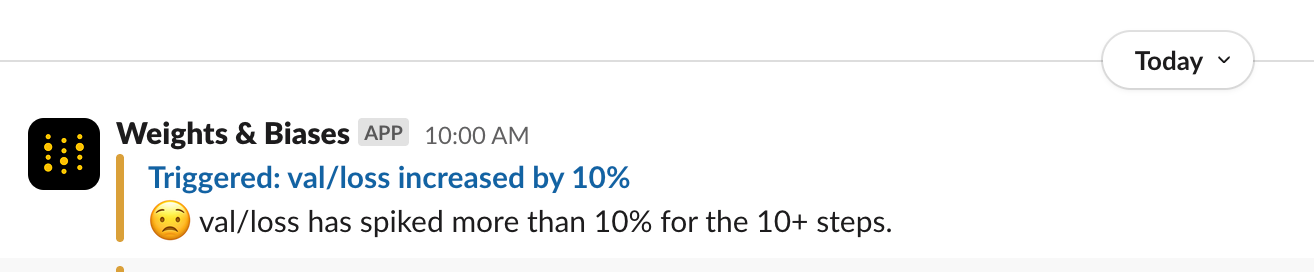

The notifications API supports a number of sceanrios, including different threshold and custom lookback periods--learn more in [the docs](https://docs.wandb.ai/ref/python/automations/).  Give it a try and let us know how automating metric spike detection works for you.